# An Analysis of Magic: The Gathering's Creatures
Welcome to Magic: The Gathering, a trading card game produced by Wizards of the Coast where each player pretends to be a wizard casting spells and summoning creatures to reduce their opponent's life points from 20 to 0. This game has been out since 1993, and has changed dramatically since then, with the game increasing in power level and complexity over its 30 years of existence. 

## Vocabulary
Throughout the analysis I will use several Magic: the Gathering specific terms. While it is not necessary to have played magic to understand this analysis, the following definition will certainly be helpful. 

  1. Mana: The elemental magic used to cast spells, which is generated from land cards. Each card has its own mana cost, which denotes the amount and type of mana that it requires. There are five types of mana: green (G), white (W), black (B), blue (U), and red (R), each with their own types of spells they like to cast. 
  2. Set: Magic cards are released periodically in groups called "sets" which contain a few hundred magic cards each.
  3. Type: Each card has a different type; for the purpose of this analysis, we will be focusing on creatures. Creatures represent minions you can summon to help you fight your opponent. Each creature has a mana cost, a power (its strength), a toughness (its health), a few types (like Human, Elf, Dragon, etc.), and its abilities. 
  4. Keyword: Some abilities of creatures are c
  5. Ability:

Here we import all necessary modules for the project.

In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import re
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression

## Data Processing

The data we will use is from [scryfall](https://scryfall.com/), a community-ran magic the gathering site. Scryfall's data is often more reliable and accurate than the data that Wizards produces, and it is also freely available for download through their API. This data contains every single card in Magic's history that was printed in English - 78,242 card objects. However, many of these objects are extraneous and would hurt our data analysis. For the next section, I will prune down these cards to exclude reprinted cards, illegal cards, joke cards, and many other types of cards that have been created over the years.

In [2]:
URL = "https://data.scryfall.io/default-cards/default-cards-20221212220657.json"
full_scryfall_df = pd.DataFrame(json.loads(requests.get(URL).text))
full_scryfall_df.head()

,object,id,oracle_id,multiverse_ids,mtgo_id,mtgo_foil_id,tcgplayer_id,cardmarket_id,name,lang,...,tcgplayer_etched_id,attraction_lights,color_indicator,life_modifier,hand_modifier,printed_type_line,printed_text,content_warning,flavor_name,variation_of
0,card,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,[109722],25527.0,25528.0,14240.0,13850.0,Fury Sliver,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,[189637],34586.0,34587.0,33347.0,21851.0,Kor Outfitter,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,card,0000a54c-a511-4925-92dc-01b937f9afad,dc4e2134-f0c2-49aa-9ea3-ebf83af1445c,[],NaN,NaN,98659.0,NaN,Spirit,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,card,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,[435231],65170.0,65171.0,145764.0,301766.0,Siren Lookout,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,card,00012bd8-ed68-4978-a22d-f450c8a6e048,5aa12aff-db3c-4be5-822b-3afdf536b33e,[1278],NaN,NaN,1623.0,5664.0,Web,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This dataframe also comes with 84 columns, many of which we do not need. I will remove all columns except for the useful ones in determining a card's qualities, and in determining whether we want to analyze the card or not.

In [3]:
df = full_scryfall_df[['name',                       # the name of the card - not technically necessary but helpful for debugging
                       'mana_cost',                  # what type of mana the card costs to summon
                       'cmc',                        # how much mana the card costs
                       'type_line',                  # the type of the card (creature, sorcery, etc)
                       'oracle_text',                # what the card does
                       'power', 'toughness',         # the strength of the card if it's a creature
                       'colors', 'color_identity',   # more info on what type of mana the card costs
                       'keywords',                   # the keywords on the card (more on this later)
                       'set', 'released_at',         # when the card was released
                       'rarity',                     # how much the card was printed
                       'games',                      # games tells if it is legal online or in paper (we exclude online-only cards)
                       'legalities']]                # which formats the card is legal in

First, we will remove all cards that are in there multiple times (e.g. they were printed in multiple sets). Wizards does this sometimes to bring back fan favorite cards or to have some basic cards that always work well. 

In [4]:
df = df.sort_values(by=['released_at', 'name'])
df = df.drop_duplicates(subset=['name'])

Next, we will remove online-only cards. Wizards of the Coast released a program called Magic Arena, and to promote it they released cards that were only legal for that program. However, these cards were not created with the balance of the paper format in mind, and reference random effects and things only possible online. Therefore, I am excluding them from this analysis.

In [5]:
df = df[df['games'].apply(lambda i: 'paper' in i)]

Some cards are illegal to play for power-level reasons (too strong for the format); however, we can still analyze these. The "not legal" designation means cards that are literally unplayable: they are printed alongside magic cards, but just say promotional text or act as other game pieces. Tokens are one such piece; some cards create tokens, but you can't put the actual token cards in your deck. However, Scryfall treats all of these as "card objects" and puts them in.

In [6]:
def legal(legalities):
    v = legalities.values()
    if len(set(v)) == 1 and "not_legal" in v:
        return False
    return True

df = df[df['legalities'].apply(legal)]
df = df[~df["type_line"].str.contains("Token", na=False)] # remove tokens

Finally, some cards were designed as jokes by the Wizards designers in sets called "unsets". These cards, like the online cards, aren't tuned for interacting with any other cards, and so I will exclude them from this dataset.

In [7]:
unsets = ['unglued', 'unhinged', 'unstable', 'unsanctioned', 'unfinity']
sets = json.loads(requests.get("https://api.scryfall.com/sets").text)
for s in sets["data"]:
    if s['name'].lower() in unsets:
        df = df[~df["set"].str.contains(s['code'])]

In [8]:
df["num_colored_pips"] = df["mana_cost"].apply(lambda mana_cost: len(re.findall("\{[^\d]\}", str(mana_cost))))

Let's take a look!

In [9]:
df.head()

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips
32371,Air Elemental,{3}{U}{U},5.0,Creature — Elemental,Flying,4,4,[U],[U],[Flying],lea,1993-08-05,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2
34504,Ancestral Recall,{U},1.0,Instant,Target player draws three cards.,NaN,NaN,[U],[U],[],lea,1993-08-05,rare,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",1
31309,Animate Artifact,{3}{U},4.0,Enchantment — Aura,Enchant artifact\nAs long as enchanted artifac...,NaN,NaN,[U],[U],[Enchant],lea,1993-08-05,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1
43897,Animate Dead,{1}{B},2.0,Enchantment — Aura,Enchant creature card in a graveyard\nWhen Ani...,NaN,NaN,[B],[B],[Enchant],lea,1993-08-05,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1
65475,Animate Wall,{W},1.0,Enchantment — Aura,Enchant Wall\nEnchanted Wall can attack as tho...,NaN,NaN,[W],[W],[Enchant],lea,1993-08-05,rare,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1


As you can see, we've now got the important parts of a card, and the cards are sorted conveniently by their release date. We are now looking at the first magic cards ever released. How strong were they? Let's find out!

## Vanilla Creature Analysis
A vanilla creature is a creature with no text whatsoever - just stats! The "classic" vanilla creature is the Grizzly Bears, a 2/2 for 2 mana in green.

In [10]:
df[df["name"].str.contains("Grizzly Bears")]

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips
63158,Grizzly Bears,{1}{G},2.0,Creature — Bear,,2,2,[G],[G],[],lea,1993-08-05,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1


However, not all creatures are created equally. For example, the Coral Eel has the same mana cost, but only 1 toughness. The difference? It's in blue!

In [11]:
df[df["name"].str.contains("Coral Eel")]

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips
16522,Coral Eel,{1}{U},2.0,Creature — Fish,,2,1,[U],[U],[],por,1997-05-01,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1


Clearly, some colors are better at producing creatures than other colors. But how much better? Let's start with vanilla creatures, since we know none of their abilities is influencing their mana cost. Therefore, we can just get a look at how much each point of power and toughness is costing, mana-wise.

In [12]:
vanilla_df = df[df["oracle_text"] == ""]
vanilla_df = vanilla_df[vanilla_df["type_line"].str.contains("Creature")]

for i in ['cmc', 'power', 'toughness']:
    vanilla_df[i] = vanilla_df[i].apply(int)

vanilla_df.head()

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips
58740,Craw Wurm,{4}{G}{G},6,Creature — Wurm,,6,4,[G],[G],[],lea,1993-08-05,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2
54563,Earth Elemental,{3}{R}{R},5,Creature — Elemental,,4,5,[R],[R],[],lea,1993-08-05,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2
66828,Fire Elemental,{3}{R}{R},5,Creature — Elemental,,5,4,[R],[R],[],lea,1993-08-05,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2
35350,Gray Ogre,{2}{R},3,Creature — Ogre,,2,2,[R],[R],[],lea,1993-08-05,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1
63158,Grizzly Bears,{1}{G},2,Creature — Bear,,2,2,[G],[G],[],lea,1993-08-05,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1


<AxesSubplot: xlabel='cmc'>

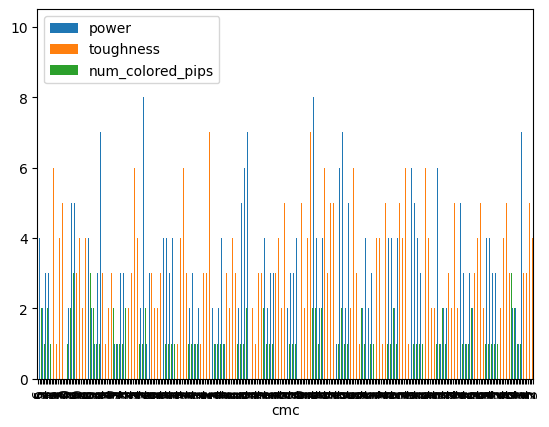

In [13]:
vanilla_df.plot.bar('cmc')

In [14]:
x = set()
for i, row in df.iterrows():
    if row['set'] not in ['afr', '40k', 'clb', 'sld']:
        x = x.union(row['keywords'])
    else:
        # ignore multimodal keywords
        x = x.union([i for i in row['keywords'] if ' ' not in i])
keyword_soup = ' '.join(x).lower()
print(keyword_soup)

landcycling escape double agenda companion convoke ravenous recover revolt blitz fuse amass detain transfigure menace trample plainscycling replicate crew improvise mill join forces surveil wizardcycling fabricate reach lieutenant morbid swampwalk heroic scavenge basic landcycling epic delve radiance surge avoidance soulbond provoke mutate dredge assist monstrosity kinship affinity living weapon inspired daybound annihilator modular hideaway kicker cleave overload emerge learn fateful hour strive ninjutsu reinforce vanishing prototype transform rally forecast delirium vigilance retrace evoke reconfigure exploit berzerker chainsword offering disturb multikicker protector shieldwall echo myriad feed spell mastery sweep outlast skulk pack tactics indestructible mentor fight forestcycling encore manifest battalion splice polymorphine mama's coming hadoken flash flanking horsemanship magecraft assemble channel devoid phaeron skyswarm read ahead cycling madness banding cumulative upkeep ward

In [15]:
removes = [r'\(.*?\)', r'\{.*?\}', r'—[^ ][^\n]*', r'(P|p)rotection(?! F)[^\n]*', r'\d*', r'Prototype[^\n]*']
#r'—[^{][^T][^\n]*', 
# todo protection, ward, a lot of stuff actually

def extract_ability_text(row):
    text = row['oracle_text']

    if text is np.nan:
        return ''
    
    for r in removes:
        text = re.sub(r, '', text)
    text = text.replace(',', '').replace(';', '')
    text = text.lower()
    text = text.strip()

    return text

def is_french_vanilla(row):
    text = row['oracle_text']
    
    if text == '': 
        return True # is just vanilla
    
    if text is np.nan:
        return False # is not valid
    
    text = extract_ability_text(row)

    for i in text.split():
        if i not in keyword_soup:
            return False

    return True

french_vanilla_df = df[df["type_line"].str.contains("Creature", na=False)] # for now just creatures
french_vanilla_df = french_vanilla_df.sort_values(by=['name'])
french_vanilla_df['is_french_vanilla'] = french_vanilla_df.apply(is_french_vanilla, axis=1)
french_vanilla_df = french_vanilla_df[french_vanilla_df['is_french_vanilla']]

french_vanilla_df = french_vanilla_df.sort_values(by=['name'])

french_vanilla_df


,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,is_french_vanilla
34736,Abbey Gargoyles,{2}{W}{W}{W},5.0,Creature — Gargoyle,"Flying, protection from red",3,4,[W],[W],"[Flying, Protection]",hml,1995-10-01,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",3,True
58613,Abbey Griffin,{3}{W},4.0,Creature — Griffin,"Flying, vigilance",2,2,[W],[W],"[Flying, Vigilance]",isd,2011-09-30,common,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",1,True
42882,Aboroth,{4}{G}{G},6.0,Creature — Elemental,Cumulative upkeep—Put a -1/-1 counter on Aboro...,9,9,[G],[G],[Cumulative upkeep],wth,1997-06-09,rare,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",2,True
8498,Abzan Guide,{3}{W}{B}{G},6.0,Creature — Human Warrior,Lifelink (Damage dealt by this creature also c...,4,4,"[B, G, W]","[B, G, W]","[Lifelink, Morph]",ktk,2014-09-26,common,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",3,True
29975,Accomplished Automaton,{7},7.0,Artifact Creature — Construct,Fabricate 1 (When this creature enters the bat...,5,7,[],[],[Fabricate],kld,2016-09-30,common,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52344,Zodiac Tiger,{2}{G}{G},4.0,Creature — Cat,Forestwalk (This creature can't be blocked as ...,3,4,[G],[G],"[Landwalk, Forestwalk]",ptk,1999-07-06,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,True
54912,Zombie Brute,{6}{B},7.0,Creature — Zombie,Amplify 1 (As this creature enters the battlef...,5,4,[B],[B],"[Amplify, Trample]",lgn,2003-02-03,uncommon,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",1,True
77725,Zombie Cutthroat,{3}{B}{B},5.0,Creature — Zombie,Morph—Pay 5 life. (You may cast this card face...,3,4,[B],[B],[Morph],scg,2003-05-26,common,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",2,True
62508,Zombie Goliath,{4}{B},5.0,Creature — Zombie Giant,,4,3,[B],[B],[],m10,2009-07-17,common,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",1,True


In [16]:
french_vanilla_df[french_vanilla_df['rarity'] == 'mythic']

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,is_french_vanilla
43836,Apex Devastator,{8}{G}{G},10.0,Creature — Chimera Hydra,"Cascade, cascade, cascade, cascade (When you c...",10,10,[G],[G],[Cascade],cmr,2020-11-20,mythic,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",2,True
31650,Baneslayer Angel,{3}{W}{W},5.0,Creature — Angel,"Flying, first strike, lifelink, protection fro...",5,5,[W],[W],"[Flying, Lifelink, First strike, Protection]",m10,2009-07-17,mythic,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",2,True
55601,Furyborn Hellkite,{4}{R}{R}{R},7.0,Creature — Dragon,Bloodthirst 6 (If an opponent was dealt damage...,6,6,[R],[R],"[Flying, Bloodthirst]",m12,2011-07-15,mythic,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",3,True
75215,Impervious Greatwurm,{7}{G}{G}{G},10.0,Creature — Wurm,Convoke (Your creatures can help cast this spe...,16,16,[G],[G],"[Indestructible, Convoke]",grn,2018-10-05,mythic,"[arena, paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",3,True
61295,Sphinx of the Steel Wind,{5}{W}{U}{B},8.0,Artifact Creature — Sphinx,"Flying, first strike, vigilance, lifelink, pro...",6,6,"[B, U, W]","[B, U, W]","[Flying, Lifelink, Vigilance, First strike, Pr...",arb,2009-04-30,mythic,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",3,True
5986,Vorapede,{2}{G}{G}{G},5.0,Creature — Insect,"Vigilance, trample\nUndying (When this creatur...",5,4,[G],[G],"[Undying, Vigilance, Trample]",dka,2012-02-03,mythic,"[paper, mtgo]","{'standard': 'not_legal', 'future': 'not_legal...",3,True


In [17]:
# todo organize code
alpha_release_date = dt.datetime(1993, 8, 5)
# ignore type line for now
data_df = french_vanilla_df.drop(columns=['name', 'mana_cost', 'type_line', 'oracle_text', 'color_identity', 'set', 'is_french_vanilla', 'games', 'legalities'])
data_df['cmc'] = data_df['cmc'].apply(int)
data_df['power'] = data_df['power'].apply(int)
data_df['toughness'] = data_df['toughness'].apply(int)
data_df['released_at'] = data_df['released_at'].apply(lambda i: (dt.datetime.strptime(i, '%Y-%m-%d').year - alpha_release_date.year))
data_df


,cmc,power,toughness,colors,keywords,released_at,rarity,num_colored_pips
34736,5,3,4,[W],"[Flying, Protection]",2,uncommon,3
58613,4,2,2,[W],"[Flying, Vigilance]",18,common,1
42882,6,9,9,[G],[Cumulative upkeep],4,rare,2
8498,6,4,4,"[B, G, W]","[Lifelink, Morph]",21,common,3
29975,7,5,7,[],[Fabricate],23,common,0
...,...,...,...,...,...,...,...,...
52344,4,3,4,[G],"[Landwalk, Forestwalk]",6,uncommon,2
54912,7,5,4,[B],"[Amplify, Trample]",10,uncommon,1
77725,5,3,4,[B],[Morph],10,common,2
62508,5,4,3,[B],[],16,common,1


In [18]:
def dummy_list(data_df, one_hot_df, column):
    x = set(data_df.explode(column)[column].values)
    x.remove(np.nan)
    
    for i in x:
        one_hot_df[f'{column}_{i}'] = data_df[column].apply(lambda j: int(i in j))
    

one_hot_df = pd.get_dummies(data_df.drop(columns=['colors', 'keywords']))
dummy_list(data_df, one_hot_df, 'colors')
dummy_list(data_df, one_hot_df, 'keywords')
one_hot_df

/var/folders/my/xjpgt3ss01991yghb67xgjs80000gn/T/ipykernel_19686/536103211.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_df[f'{column}_{i}'] = data_df[column].apply(lambda j: int(i in j))
/var/folders/my/xjpgt3ss01991yghb67xgjs80000gn/T/ipykernel_19686/536103211.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_df[f'{column}_{i}'] = data_df[column].apply(lambda j: int(i in j))
/var/folders/my/xjpgt3ss01991yghb67xgjs80000gn/T/ipykernel_19686/536103211.py:6: PerformanceWarning: DataFrame is highly fragmente

,cmc,power,toughness,released_at,num_colored_pips,rarity_common,rarity_mythic,rarity_rare,rarity_uncommon,colors_W,...,keywords_Sunburst,keywords_Amplify,keywords_Shroud,keywords_Wither,keywords_Ingest,keywords_Defender,keywords_Spectacle,keywords_Islandwalk,keywords_Infect,keywords_Suspend
34736,5,3,4,2,3,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
58613,4,2,2,18,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42882,6,9,9,4,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8498,6,4,4,21,3,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
29975,7,5,7,23,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52344,4,3,4,6,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
54912,7,5,4,10,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
77725,5,3,4,10,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62508,5,4,3,16,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# make new dummy matrices for interaction terms
X = one_hot_df.drop(columns=['cmc', 'rarity_common'])
y = one_hot_df['cmc']

# make new linear regression
reg2 = LinearRegression().fit(X, y)

# print all coefficients
for name, coef in zip(X.columns, reg2.coef_):
    print(f"{name} Coefficient: {coef}")
print("Intercept:", reg2.intercept_)


power Coefficient: 0.647653337478077
toughness Coefficient: 0.5001578967909577
released_at Coefficient: -0.026062830650072796
num_colored_pips Coefficient: -0.19644816719098834
rarity_mythic Coefficient: -2.897477353478253
rarity_rare Coefficient: -0.6249511151602726
rarity_uncommon Coefficient: -0.09550557183919905
colors_W Coefficient: -0.21631572201494742
colors_U Coefficient: -0.07181231887656825
colors_R Coefficient: -0.09110658854908316
colors_G Coefficient: -0.49195905011505703
colors_B Coefficient: -0.03673822025550072
keywords_Rampage Coefficient: 1.0890396422895283
keywords_Landcycling Coefficient: -190761076344.4706
keywords_Devour Coefficient: 0.8842680285801043
keywords_Intimidate Coefficient: 0.7503471448977047
keywords_Convoke Coefficient: 1.2436873086342426
keywords_Ripple Coefficient: 0.6355221392542425
keywords_Squad Coefficient: -31718639932.51125
keywords_Transfigure Coefficient: 0.7338404417208948
keywords_Menace Coefficient: 0.3624507248425939
keywords_Trample Coe

In [20]:
activated_abilities_df = df[df["type_line"].str.contains("Creature", na=False)]

def extract_activated_abilities(row):
    text = row['oracle_text']
    
    if text == '': 
        return [] # is just vanilla
    
    if text is np.nan:
        return [] # is not valid
    
    text = re.sub(removes[0], '', text)
    ret = []
    for i in text.split("\n"):
        if ":" in i:
#         if i.lower().split()[0].strip(",;") not in keyword_soup:
            ret.append(i.replace(row['name'], 'CARDNAME'))
    return ret
    
import collections
count = collections.defaultdict(int)
for i, row in activated_abilities_df.iterrows():
    ret = extract_activated_abilities(row)
    for j in ret:
        count[j] += 1

for k, v in count.items():
    if v > 5:
        print(k, v)


{T}: Add one mana of any color. 26
{B}: CARDNAME gets +1/+1 until end of turn. 24
{T}: Untap target land. 6
{T}: Add {G}. 25
{T}: CARDNAME deals 1 damage to any target. 23
{T}: Prevent the next 1 damage that would be dealt to any target this turn. 15
{B}: Regenerate CARDNAME. 29
{R}: CARDNAME gets +1/+0 until end of turn. 48
{G}: Regenerate CARDNAME. 12
{W}: CARDNAME gets +0/+1 until end of turn. 16
Remove three spore counters from CARDNAME: Create a 1/1 green Saproling creature token. 13
{U}: CARDNAME gains flying until end of turn. 9
{1}{G}: Regenerate CARDNAME. 12
{1}{B}: Regenerate CARDNAME. 17
{W}: CARDNAME gains vigilance until end of turn. 8
{T}: Add {C}. 8
{1}{R}: CARDNAME gets +1/+0 until end of turn. 13
{W}, {T}: Tap target creature. 17
{1}{G}: CARDNAME gets +2/+2 until end of turn. Activate only once each turn. 6
{2}, Remove a +1/+1 counter from CARDNAME: Put a +1/+1 counter on target creature. 10
{R}: CARDNAME gets +1/-1 until end of turn. 8
{0}: The next 1 damage that woul

In [54]:
# import spacy
# nlp = spacy.load("en_core_web_sm")
creature_df = df[df["type_line"].str.contains("Creature", na=False)]
creature_df["mana_cost_spaced"] = creature_df["mana_cost"].apply(lambda i: i.replace("}{", "} {") if isinstance(i, str) else i)

tokens = {'': 0}
num_tokens = 1

replaces = [
#       [",", " {comma} "],
#       [":", " {colon} "],
#       [".", " {period} "],
#       [";", " {semicolon} "],
    ["\n", " {newline} "],
#       [",", " "],
      [":", " {colon} "],
#       [".", " "],
#       [";", " "],
#       ["\n", " "],
      ["}{", "} {"]]

def get_data(row):
    t = row["oracle_text"]
    if t is not np.nan:
        t = t.replace(row["name"], "{CARDNAME}")
        for i, j in replaces:
            t = t.replace(i, j)
        for i in ',.;':
            t = t.replace(i, ' ')
    return [row["mana_cost_spaced"], row["type_line"], row["power"], row["toughness"], t]
#     return [row["name"], row["mana_cost_spaced"], row["type_line"], row["power"], row["toughness"], row["oracle_text"]]

def process(text):
    # remove reminder text & ,.
    return re.sub(removes[0], '', text).lower().replace(',', '').replace('.', '')

for i, row in creature_df.iterrows():
    for data in get_data(row):
#         doc = row["oracle_text"] # nlp().tokens took too long but im still considering it
        if not isinstance(data, str):
            continue # split cards have no orcale text
        data = process(data)

        for token in data.split():
            if token not in tokens:
                tokens[token] = num_tokens
                num_tokens += 1

creature_df.head()


/var/folders/my/xjpgt3ss01991yghb67xgjs80000gn/T/ipykernel_19686/513916107.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creature_df["mana_cost_spaced"] = creature_df["mana_cost"].apply(lambda i: i.replace("}{", "} {") if isinstance(i, str) else i)


,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,mana_cost_spaced
32371,Air Elemental,{3}{U}{U},5.0,Creature — Elemental,Flying,4,4,[U],[U],[Flying],lea,1993-08-05,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,{3} {U} {U}
5420,Benalish Hero,{W},1.0,Creature — Human Soldier,"Banding (Any creatures with banding, and up to...",1,1,[W],[W],[Banding],lea,1993-08-05,common,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,{W}
26263,Birds of Paradise,{G},1.0,Creature — Bird,Flying\n{T}: Add one mana of any color.,0,1,[G],[G],[Flying],lea,1993-08-05,rare,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,{G}
59195,Black Knight,{B}{B},2.0,Creature — Human Knight,First strike (This creature deals combat damag...,2,2,[B],[B],"[First strike, Protection]",lea,1993-08-05,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,{B} {B}
31516,Bog Wraith,{3}{B},4.0,Creature — Wraith,Swampwalk (This creature can't be blocked as l...,3,3,[B],[B],"[Landwalk, Swampwalk]",lea,1993-08-05,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,{3} {B}


In [55]:
print(num_tokens)
tokens_list = list(tokens.keys())

2499


In [56]:
def encode(text):
    if text is np.nan:
        return []
    t = process(text).split()
    return [tokens[i] for i in t]

def encode_row(row):
    data = get_data(row)
    # todo pad mana cost & type line
    out = []
    for i in data:
        out.extend(encode(i))

    return out

def decode(encoded):
    s = " ".join(tokens_list[i] for i in encoded)
    for i, j in replaces[:-1]:
        s = s.replace(j, i + " ")
        s = s.replace(j.strip(), i + " ")
    return s

name = "Pixie Illusionist"
t = creature_df[creature_df["name"] == name].iloc[0]
print(t)
print(encode_row(t))
print(decode(encode_row(t)))

name                                                Pixie Illusionist
mana_cost                                                         {U}
cmc                                                               1.0
type_line                                    Creature — Faerie Wizard
oracle_text         Kicker {3}{G} (You may pay an additional {3}{G...
power                                                               1
toughness                                                           1
colors                                                            [U]
color_identity                                                 [G, U]
keywords                                             [Kicker, Flying]
set                                                               dmu
released_at                                                2022-09-09
rarity                                                         common
games                                            [paper, arena, mtgo]
legalities          

In [57]:
creature_df["encoded"] = creature_df.apply(encode_row, axis=1)
creature_df["encoded_length"] = creature_df["encoded"].apply(len)

/var/folders/my/xjpgt3ss01991yghb67xgjs80000gn/T/ipykernel_19686/3704158549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creature_df["encoded"] = creature_df.apply(encode_row, axis=1)
/var/folders/my/xjpgt3ss01991yghb67xgjs80000gn/T/ipykernel_19686/3704158549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creature_df["encoded_length"] = creature_df["encoded"].apply(len)


In [58]:
creature_df = creature_df[creature_df["encoded_length"] < 50]

In [59]:
total_words = max(creature_df["encoded_length"])
largest_encode = max(creature_df["encoded_length"])
creature_df[creature_df["encoded_length"] == largest_encode]

,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,released_at,rarity,games,legalities,num_colored_pips,mana_cost_spaced,encoded,encoded_length
62154,Personal Incarnation,{3}{W}{W}{W},6.0,Creature — Avatar Incarnation,{0}: The next 1 damage that would be dealt to ...,6,6,[W],[W],[],lea,1993-08-05,rare,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",3,{3} {W} {W} {W},"[1, 8, 8, 8, 3, 4, 143, 224, 95, 95, 225, 18, ...",49
29090,Petra Sphinx,{2}{W}{W}{W},5.0,Creature — Sphinx,"{T}: Target player chooses a card name, then r...",3,4,[W],[W],[],leg,1994-06-01,rare,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",3,{2} {W} {W} {W},"[109, 8, 8, 8, 3, 4, 458, 34, 6, 17, 18, 98, 1...",49
48801,Musician,{2}{U},3.0,Creature — Human Wizard,Cumulative upkeep {1} (At the beginning of you...,1,3,[U],[U],[Cumulative upkeep],ice,1995-06-03,rare,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,{2} {U},"[109, 2, 3, 4, 9, 243, 11, 34, 552, 77, 123, 1...",49
36818,Márton Stromgald,{2}{R}{R},4.0,Legendary Creature — Human Knight,"Whenever Márton Stromgald attacks, other attac...",1,1,[R],[R],[],ice,1995-06-03,rare,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",2,{2} {R} {R},"[109, 110, 110, 390, 3, 4, 9, 26, 11, 11, 86, ...",49
46310,Rogue Skycaptain,{2}{R},3.0,Creature — Human Rogue Mercenary,"Flying\nAt the beginning of your upkeep, put a...",3,4,[R],[R],[Flying],all,1996-06-10,rare,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,{2} {R},"[109, 110, 3, 4, 9, 288, 578, 34, 6, 7, 16, 49...",49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15574,Psychomancer,{1}{B},2.0,Artifact Creature — Necron Wizard,Flying\nHarbinger of Despair — Whenever Psycho...,1,1,[B],[B],"[Flying, Harbinger of Despair]",40k,2022-10-07,uncommon,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,{1} {B},"[123, 25, 37, 3, 4, 2265, 243, 11, 11, 7, 16, ...",49
29021,Triumph of Saint Katherine,{4}{W},5.0,Creature — Human Warrior,Lifelink\nPraesidium Protectiva — When Triumph...,5,5,[W],[W],"[Lifelink, Miracle, Praesidium Protectiva]",40k,2022-10-07,rare,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",1,{4} {W},"[93, 8, 3, 4, 9, 128, 97, 97, 1117, 16, 2449, ...",49
47965,Gurgling Anointer,{2}{B},3.0,Creature — Phyrexian Horror,Flying\nWhenever you draw your second card eac...,1,3,[B],[B],[Flying],bro,2022-11-18,uncommon,"[paper, arena, mtgo]","{'standard': 'legal', 'future': 'legal', 'hist...",1,{2} {B},"[109, 25, 3, 4, 360, 388, 11, 34, 7, 16, 86, 7...",49
14975,"Urza, Chief Artificer",{3}{W}{U}{B},6.0,Legendary Creature — Human Artificer,Affinity for artifact creatures (This spell co...,4,5,"[B, U, W]","[B, U, W]",[Affinity],brc,2022-11-18,mythic,[paper],"{'standard': 'not_legal', 'future': 'not_legal...",3,{3} {W} {U} {B},"[1, 8, 2, 25, 390, 3, 4, 9, 344, 6, 97, 920, 2...",49


In [60]:
input_sequences = []
for seq in creature_df["encoded"]:
#     input_sequences.append(seq)
    for i in range(1, len(seq)):
        input_sequences.append(seq[:i + 1])

In [61]:
import tensorflow.keras.utils as ku
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
total_words = num_tokens
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [62]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import tensorflow as tf

# https://github.com/nicknochnack/GANBasics/blob/main/FashionGAN-Tutorial.ipynb
# https://towardsdatascience.com/training-neural-networks-to-create-text-like-a-human-23bfdc23c28

model = Sequential()
model.add(Embedding(total_words, 240, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [63]:
max(input_sequences[:,-1])

2497

In [64]:
print(len(label[0]))
print(total_words)

2499
2499


In [ ]:
import os
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_6/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=1963)

history = model.fit(predictors, label, epochs=300, verbose=1, callbacks=[cp_callback])
 

Epoch 1/300


2022-12-13 17:56:46.461229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-13 17:56:46.896545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-13 17:56:46.920605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-13 17:56:47.259825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-13 17:56:47.488153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-13 17:56:47.823957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-13 17:56:47.858759: I tensorflow/core/grappler/optimizers/cust

1962/9048 [=====>........................] - ETA: 12:05 - loss: 4.3181 - accuracy: 0.1944
Epoch 1: saving model to training_6/cp-0001.ckpt
2059/9048 [=====>........................] - ETA: 11:56 - loss: 4.2927 - accuracy: 0.1979

In [34]:
model.load_weights("training_5/cp-0006.ckpt")

In [35]:
len(input_sequences)

377024

In [42]:
thingy = [tokens["{4}"], tokens["{g}"], tokens["{g}"]]
for i in range(40):
    X = pad_sequences([thingy], maxlen=max_sequence_len - 1, padding='pre')
    thingy.append(np.argmax(model.predict(X)))

print(thingy)
print(decode(thingy))

1/1 [==============================] - 0s 79ms/step
[95, 13, 13, 3, 4, 39, 99, 99, 232, 40, 41, 42, 43, 53, 81, 82, 677, 78, 464, 248, 60, 3, 179, 53, 63, 49, 207, 42, 43, 53, 459, 679, 25, 16, 88, 40, 137, 52, 138, 65, 60, 158, 53]
{4} {g} {g} creature — beast 5 5 when {cardname} enters the battlefield, you may search your library for a creature card, put it onto the battlefield, then shuffle.
 whenever {cardname} deals combat damage to a player , 
